<a href="https://colab.research.google.com/github/StillWork/ds-lab/blob/master/gg_z_time_series_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA Model for Time Series data
- 슈퍼마켓 매출 예측
- 가구 세일 데이터 사용
- download from:
https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls


In [4]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [5]:
# pd.__version__    # old version does not support xlxs file
# !pip install xlrd==1.2.0

- you can download the data from https://vizlab.tistory.com/122.
- about 3.2 MB (If size causes problems, you can convert it to a .csv file.)

## Data

In [6]:
df = pd.read_excel("Lab_65_Superstore.xls")
# df = pd.read_csv("Lab_65_Superstore.csv", encoding="CP949")
pd.concat([df.head(3), df.tail(3)])

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.960,2,0.0,41.9136
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.940,3,0.0,219.5820
2,3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2,0.0,6.8714
9991,9992,CA-2018-121258,2018-02-26,2018-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627.0,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.576,2,0.2,19.3932
9992,9993,CA-2018-121258,2018-02-26,2018-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627.0,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.600,4,0.0,13.3200
9993,9994,CA-2018-119914,2018-05-04,2018-05-09,Second Class,CC-12220,Chris Cortes,Consumer,United States,Westminster,...,92683.0,West,OFF-AP-10002684,Office Supplies,Appliances,"Acco 7-Outlet Masterpiece Power Center, Wihtou...",243.160,2,0.0,72.9480


In [7]:
df.shape, df.columns

((9994, 21),
 Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
        'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
        'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
        'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
       dtype='object'))

In [8]:
print(df['Order ID'].unique())
print(df['Ship Mode'].unique())
print(df['Segment'].unique())
print(df['Category'].unique())
print(df['Sub-Category'].unique())

['CA-2017-152156' 'CA-2017-138688' 'US-2016-108966' ... 'CA-2015-110422'
 'CA-2018-121258' 'CA-2018-119914']
['Second Class' 'Standard Class' 'First Class' 'Same Day']
['Consumer' 'Corporate' 'Home Office']
['Furniture' 'Office Supplies' 'Technology']
['Bookcases' 'Chairs' 'Labels' 'Tables' 'Storage' 'Furnishings' 'Art'
 'Phones' 'Binders' 'Appliances' 'Paper' 'Accessories' 'Envelopes'
 'Fasteners' 'Supplies' 'Machines' 'Copiers']


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9983 non-null   float64       
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [10]:
# df['Order Date']= pd.to_datetime(df['Order Date'])  # already done
# df['Ship Date']= pd.to_datetime(df['Ship Date'])
# df.dtypes

- furniture 매출만 보자

In [11]:
df['Category'].value_counts()

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

In [12]:
furniture = df.loc[df['Category'] == 'Furniture']
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2015-01-06 00:00:00'), Timestamp('2018-12-30 00:00:00'))

In [13]:
furniture = furniture[["Order Date", "Sales"]]
furniture = furniture.sort_values(by='Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [14]:
furniture = furniture.set_index('Order Date')
pd.concat([furniture.head(3), furniture.tail(3)])

,Sales
Order Date,
2015-01-06,2573.820
2015-01-07,76.728
2015-01-10,51.940
2018-12-29,101.120
2018-12-29,300.980
2018-12-30,323.136


- df.resample(): 월별 통계를 보기 위해 리샘플

  - Resample time-series data.
  - Convenient method for frequency conversion and resampling of time series. Object must have a datetime-like index (DatetimeIndex, PeriodIndex, or TimedeltaIndex), or pass datetime-like values to the on/level keyword.

In [15]:
furniture.info(), furniture.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2121 entries, 2015-01-06 to 2018-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   2121 non-null   float64
dtypes: float64(1)
memory usage: 33.1 KB


(None, (2121, 1))

In [16]:
furniture.index

DatetimeIndex(['2015-01-06', '2015-01-07', '2015-01-10', '2015-01-11',
               '2015-01-13', '2015-01-13', '2015-01-14', '2015-01-16',
               '2015-01-19', '2015-01-20',
               ...
               '2018-12-28', '2018-12-28', '2018-12-28', '2018-12-29',
               '2018-12-29', '2018-12-29', '2018-12-29', '2018-12-29',
               '2018-12-29', '2018-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=2121, freq=None)

In [17]:
furniture.loc['2017-01']

,Sales
Order Date,
2017-01-02,173.940
2017-01-03,1592.850
2017-01-07,23.076
2017-01-08,1565.880
2017-01-09,15.168
2017-01-10,79.920
2017-01-10,24.850
2017-01-11,54.992
2017-01-14,315.776


In [18]:
furniture.loc['2017-01'].sum()

Sales    7622.743
dtype: float64

In [19]:
furniture.loc['2017']['Sales'].resample('MS').sum()  # month start

Order Date
2017-01-01     7622.7430
2017-02-01     3925.5510
2017-03-01    12801.0920
2017-04-01    13212.0900
2017-05-01    15119.8350
2017-06-01    13070.5720
2017-07-01    13068.5190
2017-08-01    12483.2323
2017-09-01    27262.8809
2017-10-01    11872.5770
2017-11-01    31783.6288
2017-12-01    36678.7150
Freq: MS, Name: Sales, dtype: float64

In [20]:
furniture.loc['2017-01']['Sales'].mean()

346.4883181818181

In [21]:
 furniture.loc['2017']['Sales'].resample('MS').mean()

Order Date
2017-01-01    346.488318
2017-02-01    206.607947
2017-03-01    312.221756
2017-04-01    377.488286
2017-05-01    351.624070
2017-06-01    343.962421
2017-07-01    335.090231
2017-08-01    430.456286
2017-09-01    328.468445
2017-10-01    247.345354
2017-11-01    392.390479
2017-12-01    436.651369
Freq: MS, Name: Sales, dtype: float64

In [22]:
# 월별 통계로 전환
y = furniture['Sales'].resample('MS').mean()   # resample as 'Months Start'
y['2017-01':]

Order Date
2017-01-01    346.488318
2017-02-01    206.607947
2017-03-01    312.221756
2017-04-01    377.488286
2017-05-01    351.624070
2017-06-01    343.962421
2017-07-01    335.090231
2017-08-01    430.456286
2017-09-01    328.468445
2017-10-01    247.345354
2017-11-01    392.390479
2017-12-01    436.651369
2018-01-01    248.501333
2018-02-01    264.089900
2018-03-01    286.669600
2018-04-01    206.044502
2018-05-01    319.953928
2018-06-01    372.717386
2018-07-01    227.173500
2018-08-01    395.945487
2018-09-01    349.737422
2018-10-01    308.226313
2018-11-01    374.310253
2018-12-01    296.296857
Freq: MS, Name: Sales, dtype: float64

In [23]:
pd.concat([y.head(), y.tail()]) # 전체 y

Order Date
2015-01-01    312.126250
2015-02-01    262.808286
2015-03-01    441.635030
2015-04-01    305.570654
2015-05-01    288.032792
2018-08-01    395.945487
2018-09-01    349.737422
2018-10-01    308.226313
2018-11-01    374.310253
2018-12-01    296.296857
Name: Sales, dtype: float64

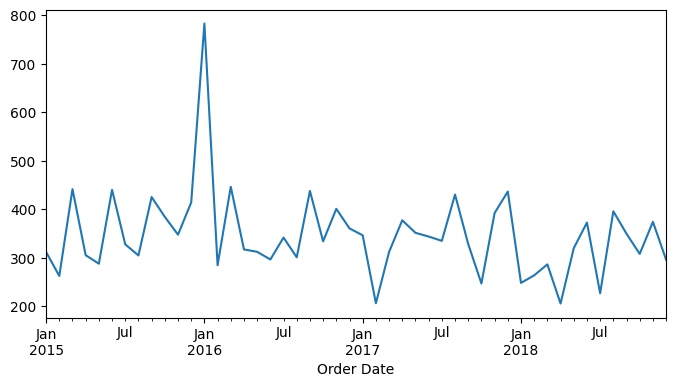

In [24]:
y.plot(figsize=(8, 4))
plt.show()

- Good Reference: https://ehfgk78.github.io/2018/01/21/DataScience07TimeSeriesData01/

## ARIMA 예측
- 시계열 데이터 기반 분석 기법
- 과거 지식이나 경험을 바탕으로 한 행동에 따라 경제가 움직이고 있음을 기초로 한다.
- 시계열 정보 -> 규칙성을 가지는 패턴과 불규칙한 패턴의 결합
  - 규칙성을 만드는 패턴:
    - 자기 상관성(Autocorrelation): 이전의 결과와 이후의 결과 사이에서 발생
    - 이동 평균(Moving Average): 이전에 생긴 불규칙한 사건이 이후의 결과에 편향성을 초래하는 현상
  - 불규칙한 패턴
     - White Noise

- AR(p) model: 예측하고자 하는 특정 변수의 과거 관측값의 선형결합으로 미래값을 예측
  - y_t: t 시점의 관측값, c: 상수, θ: 가중치, \epsilon_t: 오차항

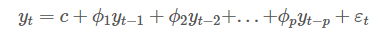

- MA(q) model: 예측오차를 이용하여 미래를 예측하는 모형

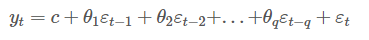

- ARMA = AR + MA
- to make non-stationary data into staionary -> use differencing (차분)
  - y' = y_t - y_(t-1) = Δy_t (1차 차분)
  - y' = y_t - y_(t-2) = Δ(2)y_t (2차 차분)
  - ...


- ARIMA(p,d,q) model: d 차 차분한 데이터의 AR(p) 와 MA(q) 모형을 합친 모형
  - y': d 차 차분 시계열, d:차분 회수
  - ARIMA(p,0,0) = AR(p), ARIMA(0,0,q) = MA(q)

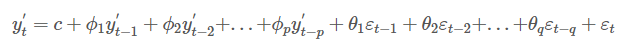

- d value: 시계열의 차이를 가져와 각 값에서 이전 값을 빼서 데이터를 더 고정시킴(statioanry)
- s: 계절적 요인 (seasonal)

- 또다른 설명:
  - 주어진 시계열은 3 개의 systematic components (level, trend, seasonality) 와 1 개의 Nonsystematic component (direct modeling 이 어려운 요소, noise)로 구성되는 것으로 생각한다.
  - 이러한 구성 요소는 다음과 같이 정의된다.
    - Level: The average value in the series.
    - Trend: The increasing or decreasing value in the series.
    - Seasonality: The repeating short-term cycle in the series.
    - Noise: The random variation in the series.
  - Additive model: 위의 모든 요소들이 더하기 형식으로 이루어짐.
- ARIMA 를 이용한 판매량 예측
  - 다음 변수를 찾기 위해 먼저 시계열 데이터를 분해해야 함.
  - seasonality, trend and noise: ARIMA(p, d, q):

  - seasonal decompose(): Seasonal decomposition using moving averages
    - partitioning a signal into seasonal, trend, residual
  - 아래는 이를 수행해주는 함수이다.
    - arrays for seasonality, trend
    - residual (time series after the trend, and seasonal components are removed)
    - observed: original data

- Tools
  - seasonal_decompose(): for exploratory data analysis to gain insights into the various components of the data (preliminary step): seasonal_decompose() gives you these components (trend, seasonal, and residual) to help you understand the underlying patterns, but they are not directly equivalent to the components in the ARIMA model.
  - SARIMAX(): modeling and forecasting

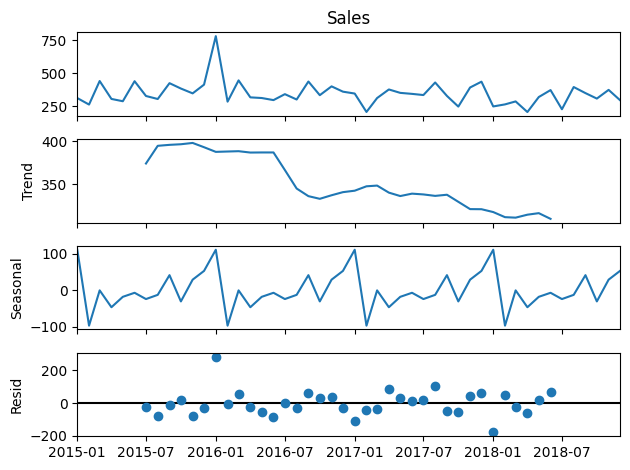

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

- SARIMA (Seasonal ARIMA):  adds an MA(4) term to the ARIMA(1,1,1) specification to allow for an additive seasonal effect.
- 여러 경우의 p, d, q 조합을 만들고 어떤 모델이 가장 실제 데이터를 잘 설명하는지 찾아야 함.

In [26]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [27]:
print(pdq)
print(seasonal_pdq)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [28]:
# example
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


- 파라미터 선택
- SARIMAX: Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model (exogenous variable: its state is independent of the state of other variables in a system)
- Why order and seasonal_order together in SARIMAX()? The SARIMAX model incorporates both **non-seasonal** and **seasonal components** to capture the underlying patterns in the data. The combination of these components allows the model to handle both short-term and long-term variations in the time series.
- AIC(Akaike Information Criterion): It combines 'Goodness of Fit' and 'Model Complexity' by penalizing models that are too complex relative to their goodness of fit.
  - **AIC = 2 * (number of estimated parameters) - 2 * (log-likelihood of the model)**
    - likelihood: L(θ|y) - gives the probability of observing y given the parameters θ.
    - The higher the likelihood, the better the model fits the data. (log(0~1) -> -infinite ~ 0.
  - Lower AIC is better. (tradeoff between complexity and performance)
  - Thus, AIC provides a means for model selection. (A model with a lower AIC is more likely to generalize well to new, unseen data. It tends to capture the essential patterns while minimizing the influence of noise.)

### Train

In [29]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

- Many time series exhibit both non-seasonal and seasonal patterns.
  - (p,d,q): non-seasonal components
  - (P,D,Q,S): seasonal components (similar to (p,d,q) but applies to the seasonal component of the model.

- grid search

In [30]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_model = None

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,   # encforce stationarity for AR
                          enforce_invertibility=False)  # encforce stationarity for MA
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = mod

        except:
            continue

print("***")
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:688.3112416991725
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1678.8552833792103
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:426.2046489859171


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:272.09198476282904
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:452.8238602501692
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1421.4751891323956
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:295.446456472235


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:274.09198456327925
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:641.1240680666141
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2600.8176447991736


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:416.54964533646034
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:262.5230517047709


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:455.1584317342162
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2487.0595441045566
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:297.4464066250189


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:264.52300131281464
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:580.638926970597
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1334.2074580228548
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:433.3552136704604


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:274.106929574684
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:437.46040107889746
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1522.0063776784414


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:294.1158452476944
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:276.1053314166445
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:538.8964721447205


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1912.9319464368164
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:412.87269899052046
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:251.24707755083625
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:419.18397927249373


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:377.2577862539993
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:273.4032454636427


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:253.2196476462003
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:592.766149874985


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1077.4270307314714
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:427.72411597383274
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:273.582068437112
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:420.4114538992044


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1551.8637052851107
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:273.58403955659367
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:275.57843039613095
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:553.2719417804376


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2190.9453770699456
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:418.52617830891063
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:263.8216777113436
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:422.40035833220617


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:738.2951781920024
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:275.4775740530794


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:265.82121058756604
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:566.5211872508684


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1260.9043017895067
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:430.33057708179365
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:273.43213783258966
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:397.366898165161


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1411.1293415746327
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:273.441539879293
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:275.4127857749962
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:540.6257368397361


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1761.9991838953802
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:414.77261730418934


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:252.6613432747441
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:391.83032555438234


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2449.5960216796325
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:263.937108438127


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:254.6420713205906
***
Best SARIMAX(0, 1, 1)x(0, 1, 1, 12)12 model - AIC:251.24707755083625


- SARIMAX(0, 1, 1)x(0, 1, 1, 12) yields the lowest AIC value of 251

In [31]:
# define the model and fit it to the data

mod = SARIMAX(y,
              order=(0, 1, 1),
              seasonal_order=(0, 1, 1, 12))
results = mod.fit()
print(results.summary().tables[1])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9982     13.522     -0.074      0.941     -27.502      25.505
ma.S.L12      -0.9855     13.786     -0.071      0.943     -28.005      26.034
sigma2      7620.1353   1.68e+05      0.045      0.964   -3.22e+05    3.37e+05


- The wanring message indicates that the SARIMAX model is having difficulty estimating its initial parameters due to a lack of data.(need more data for better estimates)

In [33]:
# print(results.summary())

- ma.L1: the coefficient of the first lag of the MA component
- ma.S.L12: the coefficient of the first lag of the seasonal MA component. (L12 is for a period of 12 time units)
- sigma2: he estimated variance of the error term (also known as the white noise term) - difference between the observed values and the predicted values

- null hypothesis (H0): there is no significant relationship or effect (specific parameter has no effect)
  - low p-value: reject H0 (he corresponding parameter is likely significant and has a non-zero effect on the response variable.) (good fit)
  - high p-value: weaker or non-significant relationship between the predictor variable and the response variable (i.e. bad fit)

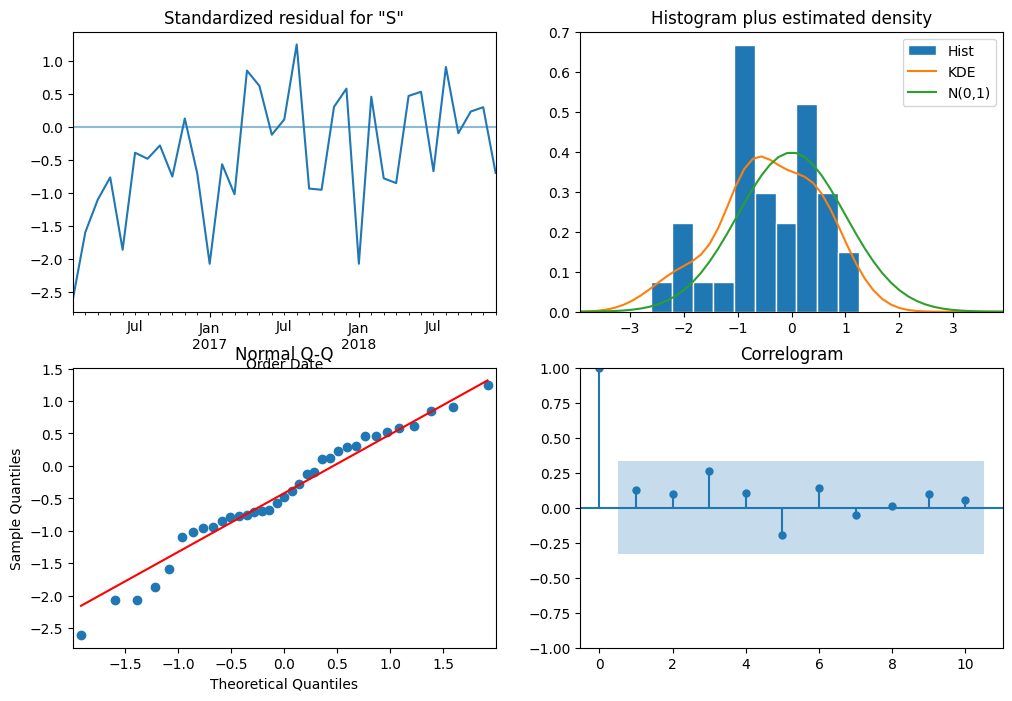

In [34]:
# 이상동작을 확인하기 위한 모델 검사(model diagnostics)
# 아래 결과를 보면 오차 (residuals)가 거의 정규분포를 따른다 - positive sign (긍정적)

results.plot_diagnostics(figsize=(12, 8))
plt.show()

- ACF: 시차에 따른 자기상관을 의미 (시차가 커질수록 ACF 는 0에 가까워진다)
  - 정상(stationary) 시계열은 상대적으로 빠르게 0에 수렴하며, 비정상(non-stationary) 시계열은 천천히 감소

### Prediction

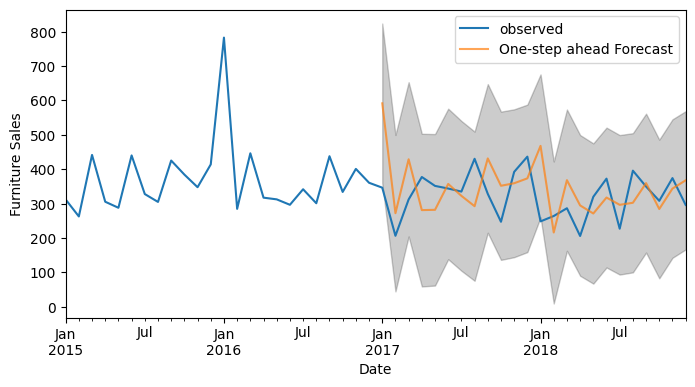

In [35]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')

pred.predicted_mean.plot(ax=ax,
                         label='One-step ahead Forecast',
                         alpha=.7,
                         figsize=(8, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [36]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE is {}'.format(round(mse, 2)))
print('RMSE is {}'.format(round(np.sqrt(mse), 2)))

MSE is 9531.22
RMSE is 97.63


- In the context of predicting a one-step ahead future value in SARIMAX():
  - For the very first prediction, you would typically use the observed historical values up to that point to estimate the initial values of the AR and MA terms.
  - For subsequent predictions, you use the predicted values from the previous time steps as inputs for the autoregressive and moving average components. This means that the predicted values at previous time steps become part of the model's input for forecasting the next step.
  - It's important to note that the accuracy of one-step ahead predictions can degrade over time, especially if the model encounters unforeseen patterns or changes in the data. This is because errors can accumulate, and the model might not fully capture sudden shifts or complex trends.

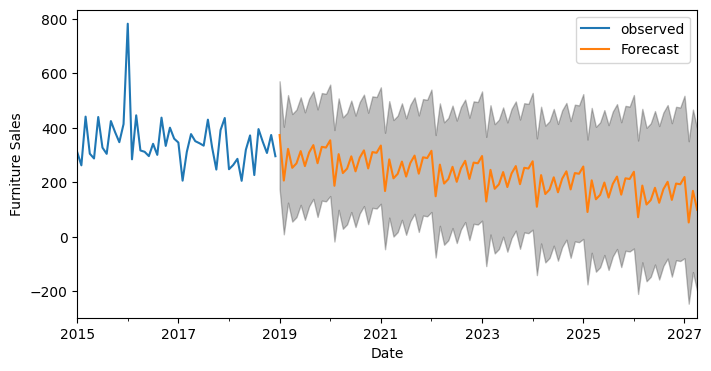

In [37]:
# confidence interval은 점차 증가한다.
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(10, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', figsize=(8, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()


- 다른 항목의 변화와 비교 가구 <-> 사무용품

In [38]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [39]:
office[:3]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
2,3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2,0.0,6.8714
4,5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368,2,0.2,2.5164
6,7,CA-2015-115812,2015-06-09,2015-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032.0,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.280,4,0.0,1.9656


In [40]:
furniture[:3]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310


In [41]:
furniture = furniture[['Order Date', 'Sales']]
office = office[['Order Date', 'Sales']]
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

In [43]:
furniture.groupby('Order Date')['Sales'].sum()

Order Date
2015-01-06    2573.8200
2015-01-07      76.7280
2015-01-10      51.9400
2015-01-11       9.9400
2015-01-13     879.9390
                ...    
2018-12-24    1393.4940
2018-12-25     832.4540
2018-12-28     551.2568
2018-12-29    2330.7180
2018-12-30     323.1360
Name: Sales, Length: 889, dtype: float64

In [46]:
furniture.groupby('Order Date')['Sales'].sum().reset_index()

,Order Date,Sales
0,2015-01-06,2573.8200
1,2015-01-07,76.7280
2,2015-01-10,51.9400
3,2015-01-11,9.9400
4,2015-01-13,879.9390
...,...,...
884,2018-12-24,1393.4940
885,2018-12-25,832.4540
886,2018-12-28,551.2568
887,2018-12-29,2330.7180


In [47]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
y_furniture = furniture['Sales'].resample('MS').mean()

office = office.groupby('Order Date')['Sales'].sum().reset_index()
office = office.set_index('Order Date')
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()


,Order Date,furniture_sales,office_sales
0,2015-01-01,480.194231,285.357647
1,2015-02-01,367.931600,63.042588
2,2015-03-01,857.291529,391.176318
3,2015-04-01,567.488357,464.794750
4,2015-05-01,432.049188,324.346545


In [48]:
store.shape

(48, 3)

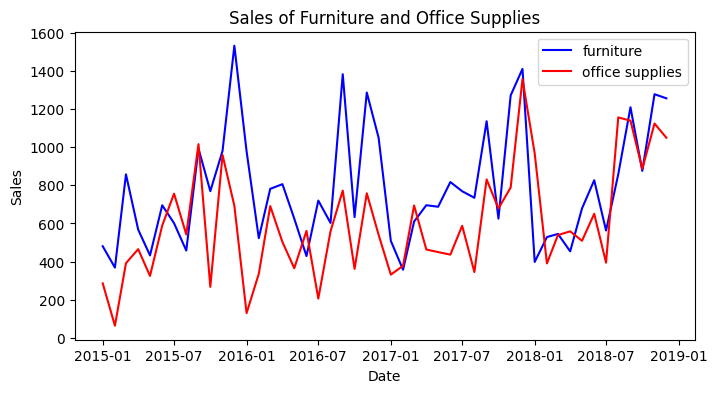

In [49]:
plt.figure(figsize=(8, 4))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales');
plt.title('Sales of Furniture and Office Supplies')
plt.legend();


- 유사한 계절적 특성을 갖는다.
- 사무용품 매출이 가구 매출을 앞지르는 시점을 찾아보겠다.

In [50]:
np.where(store['office_sales'] > store['furniture_sales'])

(array([ 6,  7,  8, 17, 25, 26, 33, 36, 39, 43, 45]),)

In [51]:
where = np.where(store['office_sales'] > store['furniture_sales'])
first_date = store.iloc[np.min(where)]['Order Date']
print("사무용품 매출이 가구매출을 앞지르는 시점: {}.".format(first_date.date()))

사무용품 매출이 가구매출을 앞지르는 시점: 2015-07-01.


# Prophet
- an open-source library for univariate (one variable) time series forecasting developed by Facebook. (2017)
- 시간 간격이 다른 샘플을 같이 분석 가능
- 휴일 등의 변수를 사용할 수 있다.

In [52]:
from prophet import Prophet

In [53]:
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'}) # column 이름을 맞춰야 함
furniture_model = Prophet(interval_width=0.95)  # uncertainty interval (confidence interval)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

# 1. create a new DataFrame that contains future timestamps (dates), and
# 2. make predictions for the future dates generated using make_future_dataframe()

furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjhnxobe5/kumcvq9r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjhnxobe5/ynmqa9pu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6432', 'data', 'file=/tmp/tmpjhnxobe5/kumcvq9r.json', 'init=/tmp/tmpjhnxobe5/ynmqa9pu.json', 'output', 'file=/tmp/tmpjhnxobe5/prophet_modelxibga4u7/prophet_model-20230914070936.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:09:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:09:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

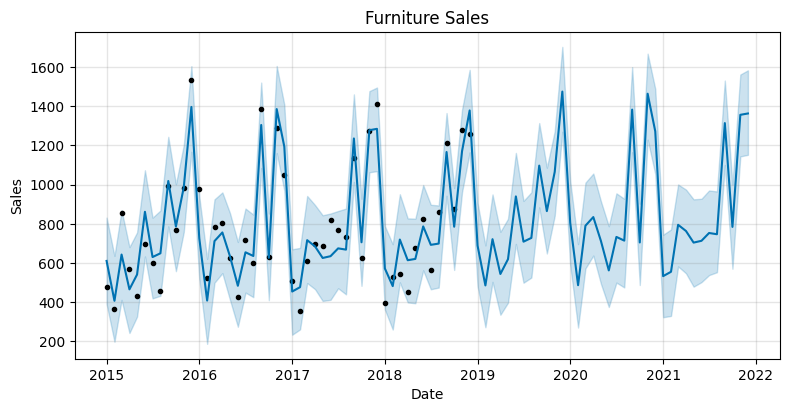

In [54]:
# plt.figure(figsize=(8, 4))
fig = furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales',
                           figsize=(8,4))
plt.title('Furniture Sales');

<Figure size 1200x400 with 0 Axes>

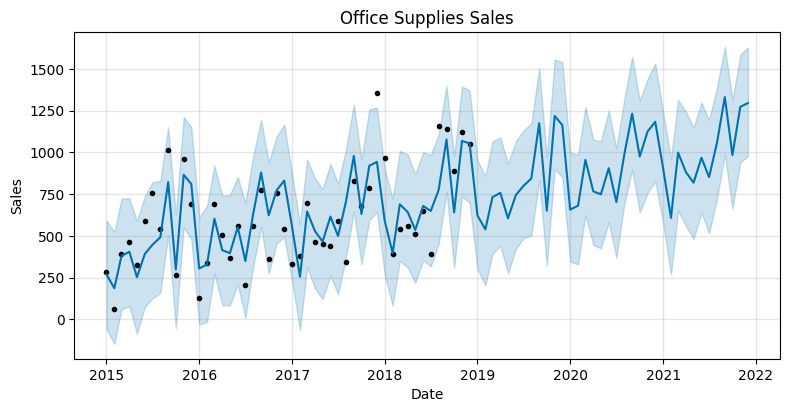

In [55]:
plt.figure(figsize=(12, 4))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales',
                  figsize=(8,4))
plt.title('Office Supplies Sales');

### 두개의 변수를 동시에 보기

In [59]:
furniture_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,737.443086,391.127933,831.359047,737.443086,737.443086,-126.835975,-126.835975,-126.835975,-126.835975,-126.835975,-126.835975,0.0,0.0,0.0,610.607110
1,2015-02-01,739.106546,198.752882,636.193676,739.106546,739.106546,-331.842365,-331.842365,-331.842365,-331.842365,-331.842365,-331.842365,0.0,0.0,0.0,407.264181
2,2015-03-01,740.609027,412.005180,869.204924,740.609027,740.609027,-97.492570,-97.492570,-97.492570,-97.492570,-97.492570,-97.492570,0.0,0.0,0.0,643.116457
3,2015-04-01,742.272487,243.319455,680.938523,742.272487,742.272487,-276.533847,-276.533847,-276.533847,-276.533847,-276.533847,-276.533847,0.0,0.0,0.0,465.738640
4,2015-05-01,743.882288,326.549146,755.868012,743.882288,743.882288,-202.808983,-202.808983,-202.808983,-202.808983,-202.808983,-202.808983,0.0,0.0,0.0,541.073304


In [60]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
merge_furniture_forecast = furniture_forecast.copy()
merge_furniture_forecast.columns = furniture_names
merge_furniture_forecast.head(3)

,furniture_ds,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,furniture_yearly_lower,furniture_yearly_upper,furniture_multiplicative_terms,furniture_multiplicative_terms_lower,furniture_multiplicative_terms_upper,furniture_yhat
0,2015-01-01,737.443086,391.127933,831.359047,737.443086,737.443086,-126.835975,-126.835975,-126.835975,-126.835975,-126.835975,-126.835975,0.0,0.0,0.0,610.607110
1,2015-02-01,739.106546,198.752882,636.193676,739.106546,739.106546,-331.842365,-331.842365,-331.842365,-331.842365,-331.842365,-331.842365,0.0,0.0,0.0,407.264181
2,2015-03-01,740.609027,412.005180,869.204924,740.609027,740.609027,-97.492570,-97.492570,-97.492570,-97.492570,-97.492570,-97.492570,0.0,0.0,0.0,643.116457


In [61]:
office_names = ['office_%s' % column for column in office_forecast.columns]
merge_office_forecast = office_forecast.copy()
merge_office_forecast.columns = office_names
merge_office_forecast.head(3)

,office_ds,office_trend,office_yhat_lower,office_yhat_upper,office_trend_lower,office_trend_upper,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2015-01-01,456.626250,-59.144452,591.432090,456.626250,456.626250,-187.489345,-187.489345,-187.489345,-187.489345,-187.489345,-187.489345,0.0,0.0,0.0,269.136905
1,2015-02-01,464.105953,-147.378177,522.402290,464.105953,464.105953,-278.220941,-278.220941,-278.220941,-278.220941,-278.220941,-278.220941,0.0,0.0,0.0,185.885012
2,2015-03-01,470.861814,58.339671,722.503031,470.861814,470.861814,-92.104692,-92.104692,-92.104692,-92.104692,-92.104692,-92.104692,0.0,0.0,0.0,378.757122


In [62]:
pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds').T

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
furniture_ds,2015-01-01 00:00:00,2015-02-01 00:00:00,2015-03-01 00:00:00,2015-04-01 00:00:00,2015-05-01 00:00:00,2015-06-01 00:00:00,2015-07-01 00:00:00,2015-08-01 00:00:00,2015-09-01 00:00:00,2015-10-01 00:00:00,...,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00,2021-10-01 00:00:00,2021-11-01 00:00:00,2021-12-01 00:00:00
furniture_trend,737.443086,739.106546,740.609027,742.272487,743.882288,745.545748,747.155549,748.819009,750.48247,752.09227,...,858.168048,859.830493,861.43931,863.101755,864.710573,866.373018,868.035462,869.64428,871.306725,872.915543
furniture_yhat_lower,391.127933,198.752882,412.00518,243.319455,326.549146,633.420518,419.748698,433.057087,786.886184,558.401079,...,582.483274,547.639694,479.36192,502.47302,538.400775,553.004936,1099.588854,570.783671,1143.057719,1151.398311
furniture_yhat_upper,831.359047,636.193676,869.204924,680.938523,755.868012,1072.678016,831.038343,867.416581,1243.05705,1001.512923,...,1000.138707,974.250516,924.56723,927.386219,969.670095,964.661085,1529.813553,999.710601,1560.519284,1581.948517
furniture_trend_lower,737.443086,739.106546,740.609027,742.272487,743.882288,745.545748,747.155549,748.819009,750.48247,752.09227,...,858.161419,859.82347,861.431885,863.093993,864.702541,866.364717,868.02674,869.635269,871.297264,872.905702
furniture_trend_upper,737.443086,739.106546,740.609027,742.272487,743.882288,745.545748,747.155549,748.819009,750.48247,752.09227,...,858.174556,859.837397,861.446626,863.109444,864.71861,866.381354,868.044182,869.653455,871.316224,872.925705
furniture_additive_terms,-126.835975,-331.842365,-97.49257,-276.533847,-202.808983,115.396313,-116.811156,-99.313349,267.444287,33.881675,...,-63.4752,-96.730519,-157.4306,-149.996706,-111.809865,-119.756957,444.983017,-85.644533,483.828832,489.112804
furniture_additive_terms_lower,-126.835975,-331.842365,-97.49257,-276.533847,-202.808983,115.396313,-116.811156,-99.313349,267.444287,33.881675,...,-63.4752,-96.730519,-157.4306,-149.996706,-111.809865,-119.756957,444.983017,-85.644533,483.828832,489.112804
furniture_additive_terms_upper,-126.835975,-331.842365,-97.49257,-276.533847,-202.808983,115.396313,-116.811156,-99.313349,267.444287,33.881675,...,-63.4752,-96.730519,-157.4306,-149.996706,-111.809865,-119.756957,444.983017,-85.644533,483.828832,489.112804
furniture_yearly,-126.835975,-331.842365,-97.49257,-276.533847,-202.808983,115.396313,-116.811156,-99.313349,267.444287,33.881675,...,-63.4752,-96.730519,-157.4306,-149.996706,-111.809865,-119.756957,444.983017,-85.644533,483.828832,489.112804


In [63]:
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()


,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2015-01-01,737.443086,391.127933,831.359047,737.443086,737.443086,-126.835975,-126.835975,-126.835975,-126.835975,...,-187.489345,-187.489345,-187.489345,-187.489345,-187.489345,-187.489345,0.0,0.0,0.0,269.136905
1,2015-02-01,739.106546,198.752882,636.193676,739.106546,739.106546,-331.842365,-331.842365,-331.842365,-331.842365,...,-278.220941,-278.220941,-278.220941,-278.220941,-278.220941,-278.220941,0.0,0.0,0.0,185.885012
2,2015-03-01,740.609027,412.005180,869.204924,740.609027,740.609027,-97.492570,-97.492570,-97.492570,-97.492570,...,-92.104692,-92.104692,-92.104692,-92.104692,-92.104692,-92.104692,0.0,0.0,0.0,378.757122
3,2015-04-01,742.272487,243.319455,680.938523,742.272487,742.272487,-276.533847,-276.533847,-276.533847,-276.533847,...,-73.556501,-73.556501,-73.556501,-73.556501,-73.556501,-73.556501,0.0,0.0,0.0,404.785016
4,2015-05-01,743.882288,326.549146,755.868012,743.882288,743.882288,-202.808983,-202.808983,-202.808983,-202.808983,...,-233.460059,-233.460059,-233.460059,-233.460059,-233.460059,-233.460059,0.0,0.0,0.0,252.119880


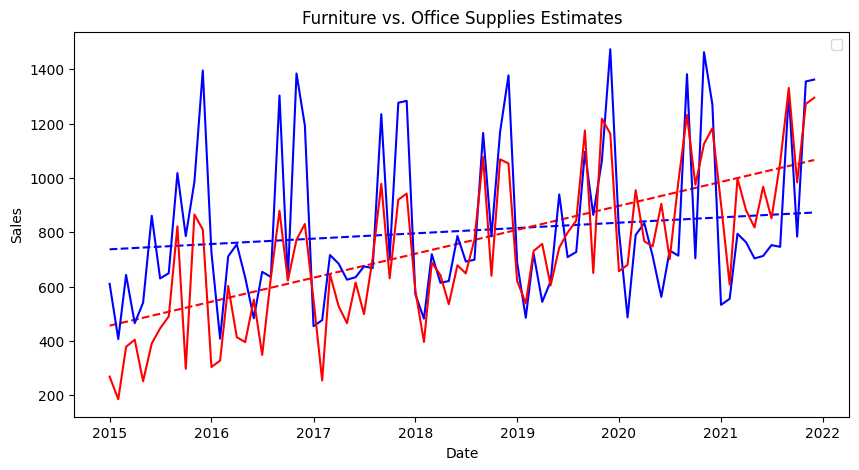

In [64]:
# 트렌드 시각화
plt.figure(figsize=(10, 5))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b--')  # trend
plt.plot(forecast['Date'], forecast['office_trend'], 'r--')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

# plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')    # estimates
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimates');


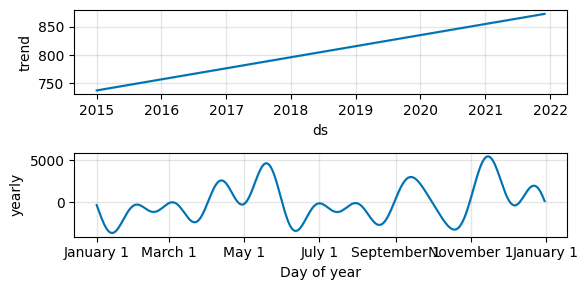

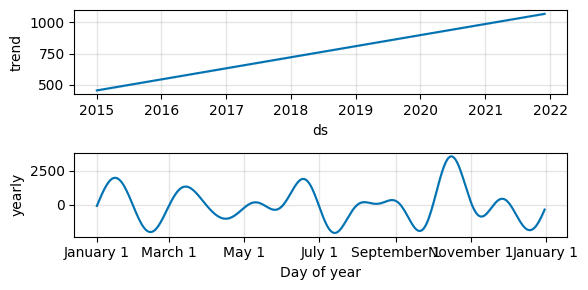

In [65]:
furniture_model.plot_components(furniture_forecast, figsize=(6,3));
office_model.plot_components(office_forecast, figsize=(6,3));

- 지금까지 SARIMAX() 및 Prophet() 모델의 활용 예를 보여 주었음. 자세한 성능 분석이나 더 상세한 활용에 대해서는 관련 사이트에 있는 매뉴얼이나 예제 코드를 참고하기 바람.

# Exercise

In [ ]:
a = np.arange(10)
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
np.where(a < 5, a+10, a*100)   # condition 을 기준으로 다른 계산

array([ 10,  11,  12,  13,  14, 500, 600, 700, 800, 900])

In [ ]:
np.where(a < 5)

(array([0, 1, 2, 3, 4]),)

In [ ]:
try:
    print(5/0)
except:    # 예외가 발생했을 때 실행됨
    print('예외가 발생했습니다.')
finally:
    print("try 문의 예외 상관없이 항상 실행...")

예외가 발생했습니다.
try 문의 예외 상관없이 항상 실행...


In [ ]:
# just for checking
list(itertools.product('ABC', repeat=2))

[('A', 'A'),
 ('A', 'B'),
 ('A', 'C'),
 ('B', 'A'),
 ('B', 'B'),
 ('B', 'C'),
 ('C', 'A'),
 ('C', 'B'),
 ('C', 'C')]

In [ ]:
list(itertools.product(range(2), range(2), range(2)))

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

- df.groupby(): to group the data by the unique values in the 'car' column

In [44]:
import pandas as pd

data = {
'co2': [95, 90, 99, 104, 105, 94, 99, 104],
'model': ['Citigo', 'Fabia', 'Fiesta', 'Rapid', 'Focus', 'Mondeo', 'Octavia', 'B-Max'],
'car': ['Skoda', 'Skoda', 'Ford', 'Skoda', 'Ford', 'Ford', 'Skoda', 'Ford']
}

df = pd.DataFrame(data)
df

,co2,model,car
0,95,Citigo,Skoda
1,90,Fabia,Skoda
2,99,Fiesta,Ford
3,104,Rapid,Skoda
4,105,Focus,Ford
5,94,Mondeo,Ford
6,99,Octavia,Skoda
7,104,B-Max,Ford


In [45]:
df.groupby(["car"]).mean()

<ipython-input-45-1402c395ad70>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(["car"]).mean()


,co2
car,
Ford,100.5
Skoda,97.0


## Prophet
  - https://facebook.github.io/prophet/docs/quick_start.html

In [ ]:
import pandas as pd
from prophet import Prophet

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
pd.concat([df.head(3), df.tail(3)])

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871
2904,2016-01-20,8.891374


In [ ]:
df.dtypes

ds     object
y     float64
dtype: object

In [ ]:
df['ds'] = pd.to_datetime(df['ds'])

In [ ]:
m = Prophet()
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp798477gl/xwbjeqkx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp798477gl/r9ylh0xq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25653', 'data', 'file=/tmp/tmp798477gl/xwbjeqkx.json', 'init=/tmp/tmp798477gl/r9ylh0xq.json', 'output', 'file=/tmp/tmp798477gl/prophet_modelnbncvs1l/prophet_model-20230808064549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:45:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:45:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=365)
pd.concat([future.head(3), future.tail(3)])

,ds
0,2007-12-10
1,2007-12-11
2,2007-12-12
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.208305,7.483010,8.936506
3266,2017-01-16,8.533309,7.786469,9.204176
3267,2017-01-17,8.320714,7.646236,9.048642
3268,2017-01-18,8.153356,7.420260,8.855077
3269,2017-01-19,8.165279,7.415628,8.884311


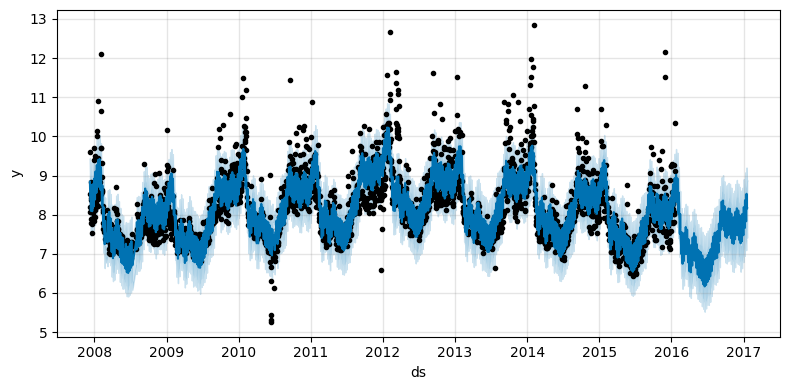

In [ ]:
# plt.figure(figsize=(8,4))
fig1 = m.plot(forecast, figsize=(8,4))

- If you want to see the forecast components, you can use the Prophet.plot_components method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.

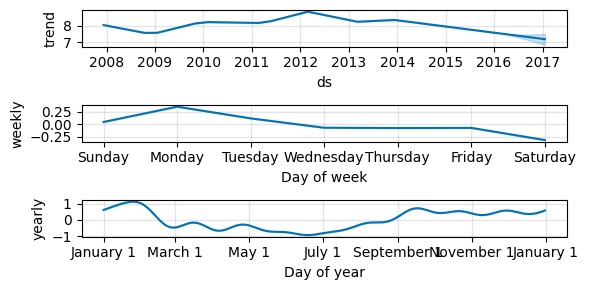

In [ ]:
fig2 = m.plot_components(forecast, figsize=(6,3))

- let's see the estimates and rel values altogether in a single graph

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp798477gl/3ju6bzup.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp798477gl/gomvy3qg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98524', 'data', 'file=/tmp/tmp798477gl/3ju6bzup.json', 'init=/tmp/tmp798477gl/gomvy3qg.json', 'output', 'file=/tmp/tmp798477gl/prophet_modelwosp6c5f/prophet_model-20230808064553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:45:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:45:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


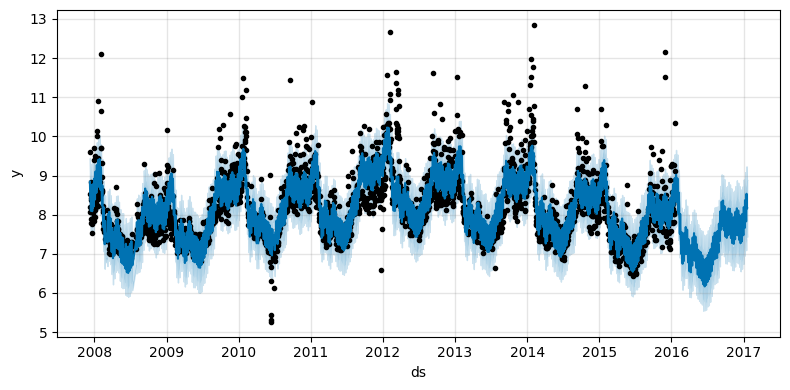

In [ ]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast, figsize=(8,4))

In [ ]:
predicted_df = forecast[['ds', 'yhat']]
pd.concat([predicted_df.head(3),predicted_df.tail(3)])

,ds,yhat
0,2007-12-10,8.842064
1,2007-12-11,8.590598
2,2007-12-12,8.386452
3267,2017-01-17,8.320714
3268,2017-01-18,8.153356
3269,2017-01-19,8.165279


In [ ]:
pd.concat([df.head(3),df.tail(3)])

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871
2904,2016-01-20,8.891374


In [ ]:
df.dtypes , predicted_df.dtypes

(ds    datetime64[ns]
 y            float64
 dtype: object,
 ds      datetime64[ns]
 yhat           float64
 dtype: object)

In [ ]:
# Merge the actual and predicted DataFrames on the 'ds' column
merged_df = pd.merge(df, predicted_df, on='ds', how='outer')
pd.concat([merged_df.head(3), merged_df.tail(3)])

,ds,y,yhat
0,2007-12-10,9.590761,8.842064
1,2007-12-11,8.519590,8.590598
2,2007-12-12,8.183677,8.386452
3267,2017-01-17,NaN,8.320714
3268,2017-01-18,NaN,8.153356
3269,2017-01-19,NaN,8.165279


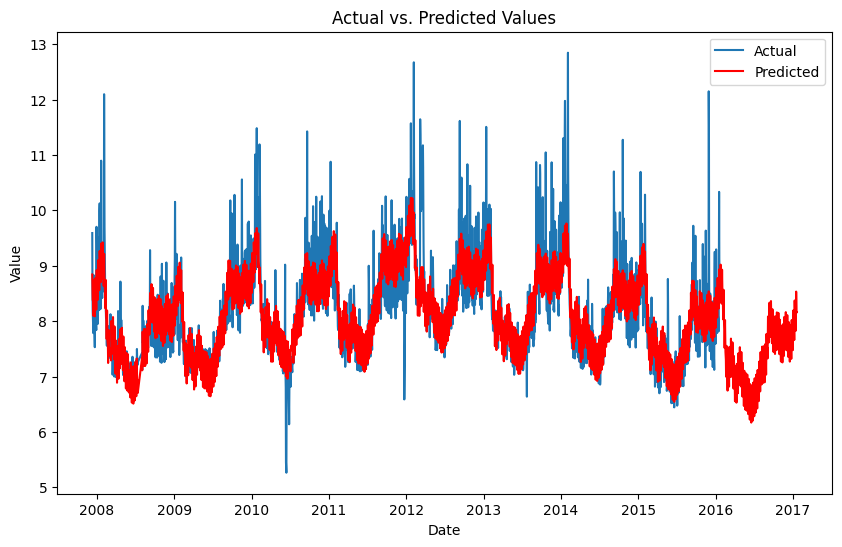

In [ ]:
# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(merged_df['ds'], merged_df['y'], label='Actual')
plt.plot(merged_df['ds'], merged_df['yhat'], label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()